<a href="https://colab.research.google.com/github/suimn416/2019.Spring.AI_Leader/blob/master/infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 경로 설정 요구사항
## query_dir : 
쿼리 이미지가 들어가는 디렉토리  

query_dir 변수에 설정된 디렉토리 안에 아무이름을 가진 디렉토리를 하나 만들고 그 안에 검색할 이미지를 저장되게 해주세요.

ex) 

/home/dh/input/query/1.jpg  **O** 이렇게 저장되게 해주세요.

/home/dh/input/1.jpg   **X** 이렇게 저장되면 안됩니다.

## refer_dir : 
test 데이터셋 디렉토리

## ckpt_path : 
체크포인트가 담긴 디렉토리

## output_dir : 
최종적으로 쿼리 이미지와 유사한 5개 이미지가 저장될 디렉토리


In [0]:
query_dir ='/content/gdrive/My Drive/input'
refer_dir ='/content/gdrive/My Drive/AILeader_Dataset/test'
ckpt_path = '/content/gdrive/My Drive/AILeader_Dataset/Checkpoint_jw/model_49.pt'
output_dir = '/content/gdrive/My Drive/output'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf

from torch.autograd import Variable
from torchvision.models import resnet18

from tensorflow import keras
from keras.preprocessing import image

import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

Using TensorFlow backend.


In [3]:
torch.manual_seed(777)

In [4]:
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
    drive.mount('/content/gdrive')
    print('Google Drive is mounted\n')
else:
    print('Google Drive is already mounted\n')

Google Drive is already mounted



In [0]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=7, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad


In [0]:
class EmbedNet(nn.Module):
    def __init__(self, base_model, net_vlad):
        super(EmbedNet, self).__init__()
        self.base_model = base_model
        self.net_vlad = net_vlad

    def forward(self, x):
        x = self.base_model(x)
        embedded_x = self.net_vlad(x)
        return embedded_x
      
class TripletNet(nn.Module):
    def __init__(self, embed_net):
        super(TripletNet, self).__init__()
        self.embed_net = embed_net

    def forward(self, a, p, n):
        embedded_a = self.embed_net(a)
        embedded_p = self.embed_net(p)
        embedded_n = self.embed_net(n)
        return embedded_a, embedded_p, embedded_n

    def feature_extract(self, x):
        return self.embed_net(x)

In [0]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.1)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (i_equal_k ^ 1)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

In [0]:
# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
# encoder = torch.load('/content/gdrive/My Drive/AILeader_Dataset/resnet18-5c106cde.pth')

In [0]:
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4,
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=7, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad).cuda()

In [10]:
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),                    #이미지의 크기
#     torchvision.transforms.ColorJitter(hue=.05, saturation=.05), #사진의 밝기를 변화시키는 코드
#     torchvision.transforms.RandomHorizontalFlip(),               #죄우 대칭을 위한 코드
    torchvision.transforms.ToTensor()
    
])

query_imagenet_data = torchvision.datasets.ImageFolder(query_dir, transform=transforms)
query_data_loader = torch.utils.data.DataLoader(query_imagenet_data,
                                          shuffle=False,
                                          batch_size=5,
                                          num_workers=0)

refer_imagenet_data = torchvision.datasets.ImageFolder(refer_dir, transform=transforms)
refer_data_loader = torch.utils.data.DataLoader(refer_imagenet_data,
                                          shuffle=False,
                                          batch_size=105,
                                          num_workers=0)

In [0]:
refer_np =None
query_np = None

for query_image,query_label in query_data_loader :
  query_output = model(query_image.cuda()) 
  X_query = query_output.cpu().data.numpy()
  
  query_np = query_image.cpu().data.numpy()
  
for refer_image,refer_label in refer_data_loader :
  refer_output = model(refer_image.cuda()) 
  X_refer = refer_output.cpu().data.numpy()
  Y_refer = refer_label.cpu().data.numpy()
  
  refer_np = refer_image.cpu().data.numpy()

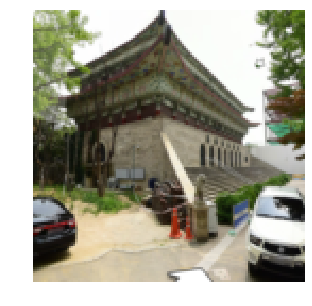

In [13]:
# query_img = np.transpose(query_np, (0, 2, 3, 1))
# plt.figure(figsize=(5,5))
# plt.axis('off')
# plt.imshow(query_img[1])

In [0]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=7, algorithm ='ball_tree').fit(X_refer)
distances, indices = nbrs.kneighbors(X_query[1:2])

In [0]:
import itertools

keys = np.ndarray.tolist(indices[0]) 
values = np.ndarray.tolist(distances[0]) 

find_dict = dict(zip(keys,values)) 

In [0]:
similar = sorted(find_dict.items(), key=lambda find_dict: values)[:5]
similar_idx = [i[0] for i in similar]

In [0]:
refer_img = np.transpose(refer_np, (0, 2, 3, 1))

idx = 0
for i in similar_idx:
  idx+=1
  rescaled = (255.0 / refer_img[i].max() * (refer_img[i] - refer_img[i].min())).astype(np.uint8)
  im = PIL.Image.fromarray(rescaled)
  im.save(os.path.join(output_dir,'{}.jpg'.format(idx)))

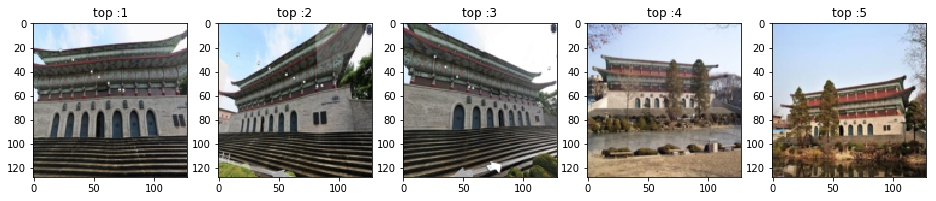

In [18]:
# fig=plt.figure(figsize=(16, 16))
# columns = 5
# rows = 1
# ax = []

# idx = 0
# for i in range(rows):
#   for j in similar_idx:
#     idx+=1
#     ax.append( fig.add_subplot(rows, columns, idx) )
#     ax[-1].set_title("top :"+str(idx))  # set title
#     plt.imshow(refer_img[j])

# plt.show()